# Mortgage Loan Approval Prediction Model

by Michael Savin

# 0. Importing


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from IPython.display import Image
import warnings

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, auc, roc_auc_score, mean_squared_error, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Load data
data = pd.read_csv('train.csv')

# 1. Data Exploration



Head of data:

                                         agency     loan_type  \
0  Department of Housing and Urban Development  Conventional   
1  Department of Housing and Urban Development  Conventional   
2         National Credit Union Administration  Conventional   
3  Department of Housing and Urban Development   FHA-insured   
4         Consumer Financial Protection Bureau  Conventional   

                                       property_type      loan_purpose  \
0  One-to-four family dwelling (other than manufa...       Refinancing   
1  One-to-four family dwelling (other than manufa...       Refinancing   
2  One-to-four family dwelling (other than manufa...       Refinancing   
3  One-to-four family dwelling (other than manufa...               NaN   
4                               Manufactured housing  Home improvement   

                              owner_occupancy  loan_amount     preapproval  \
0      Owner-occupied as a principal dwelling        160.0  Not applicable

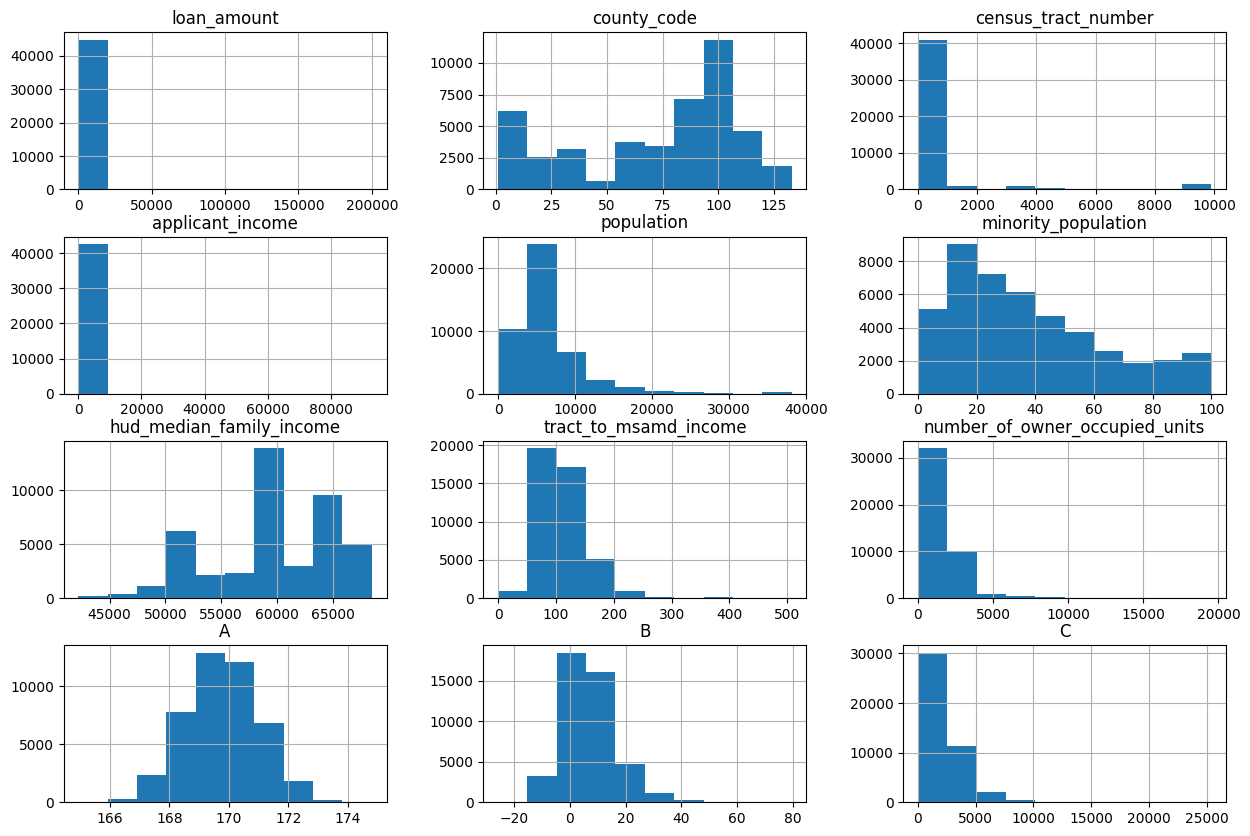



Boxplots of data:




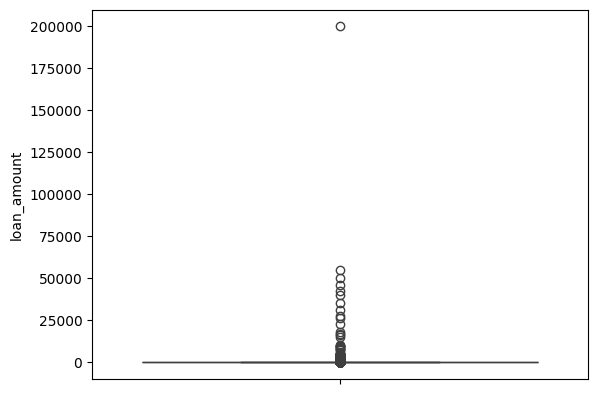

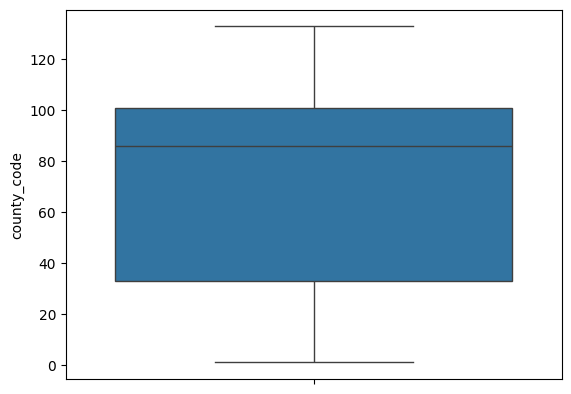

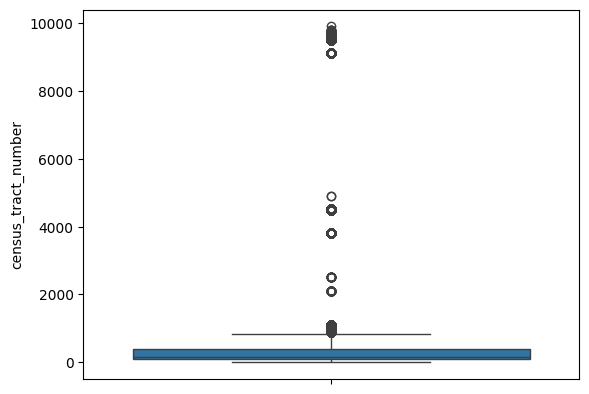

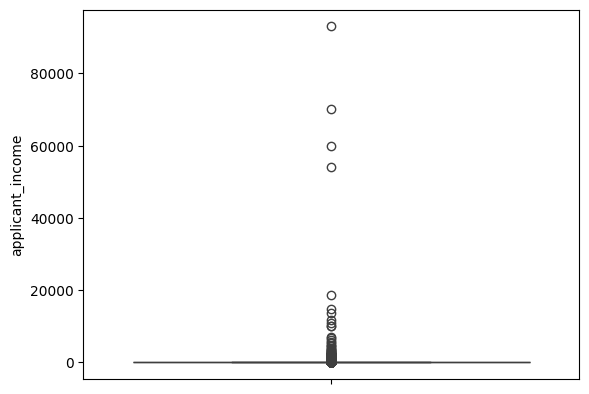

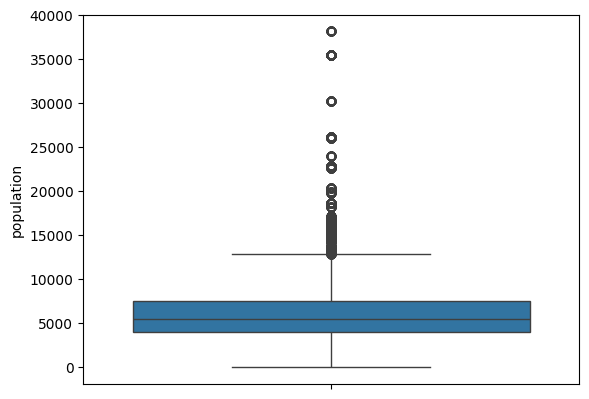

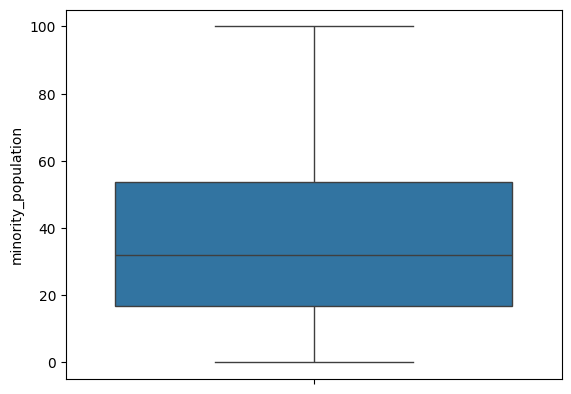

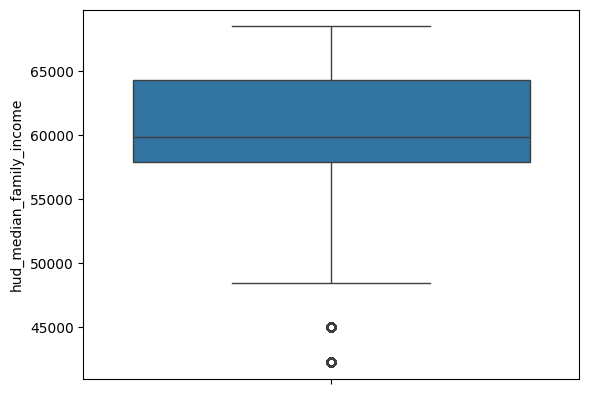

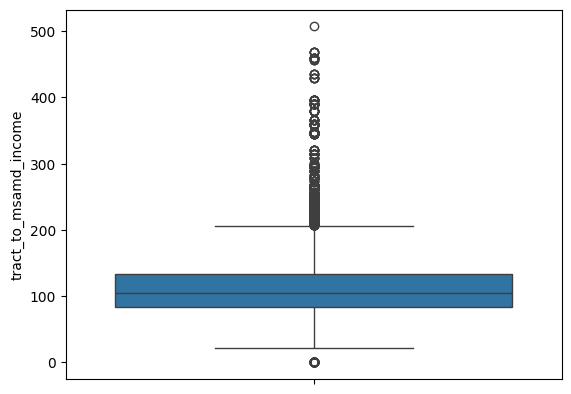

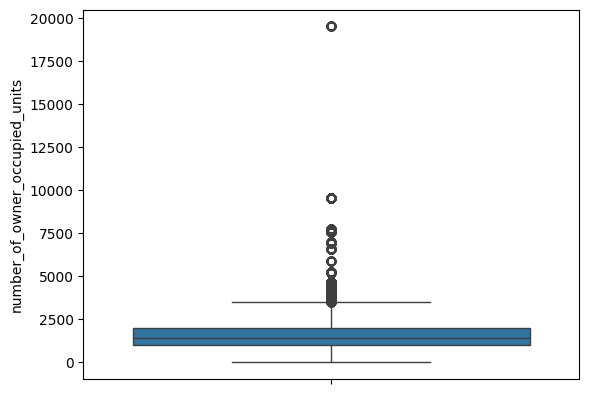

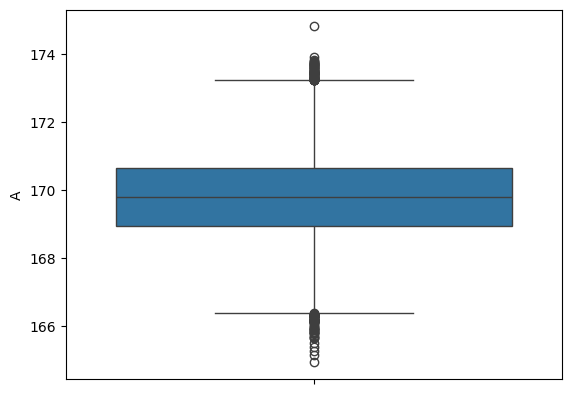

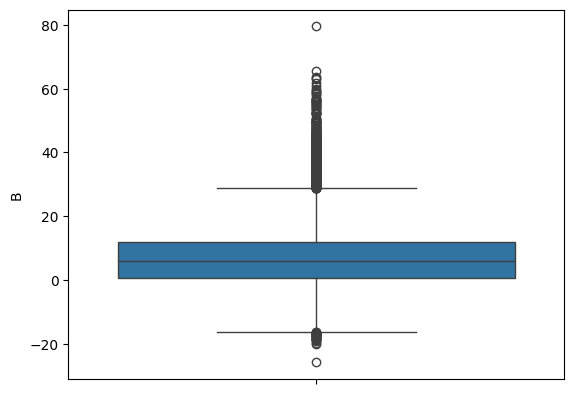

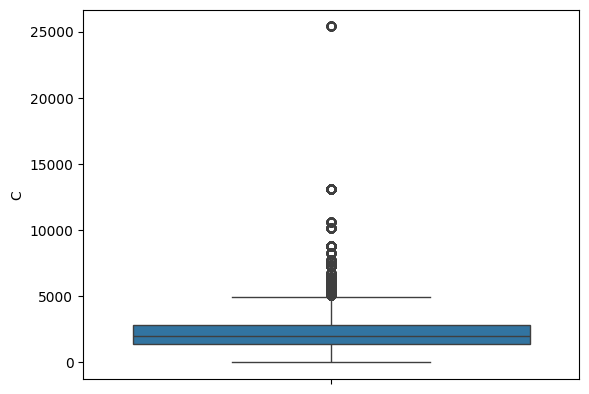



Relationships between features:




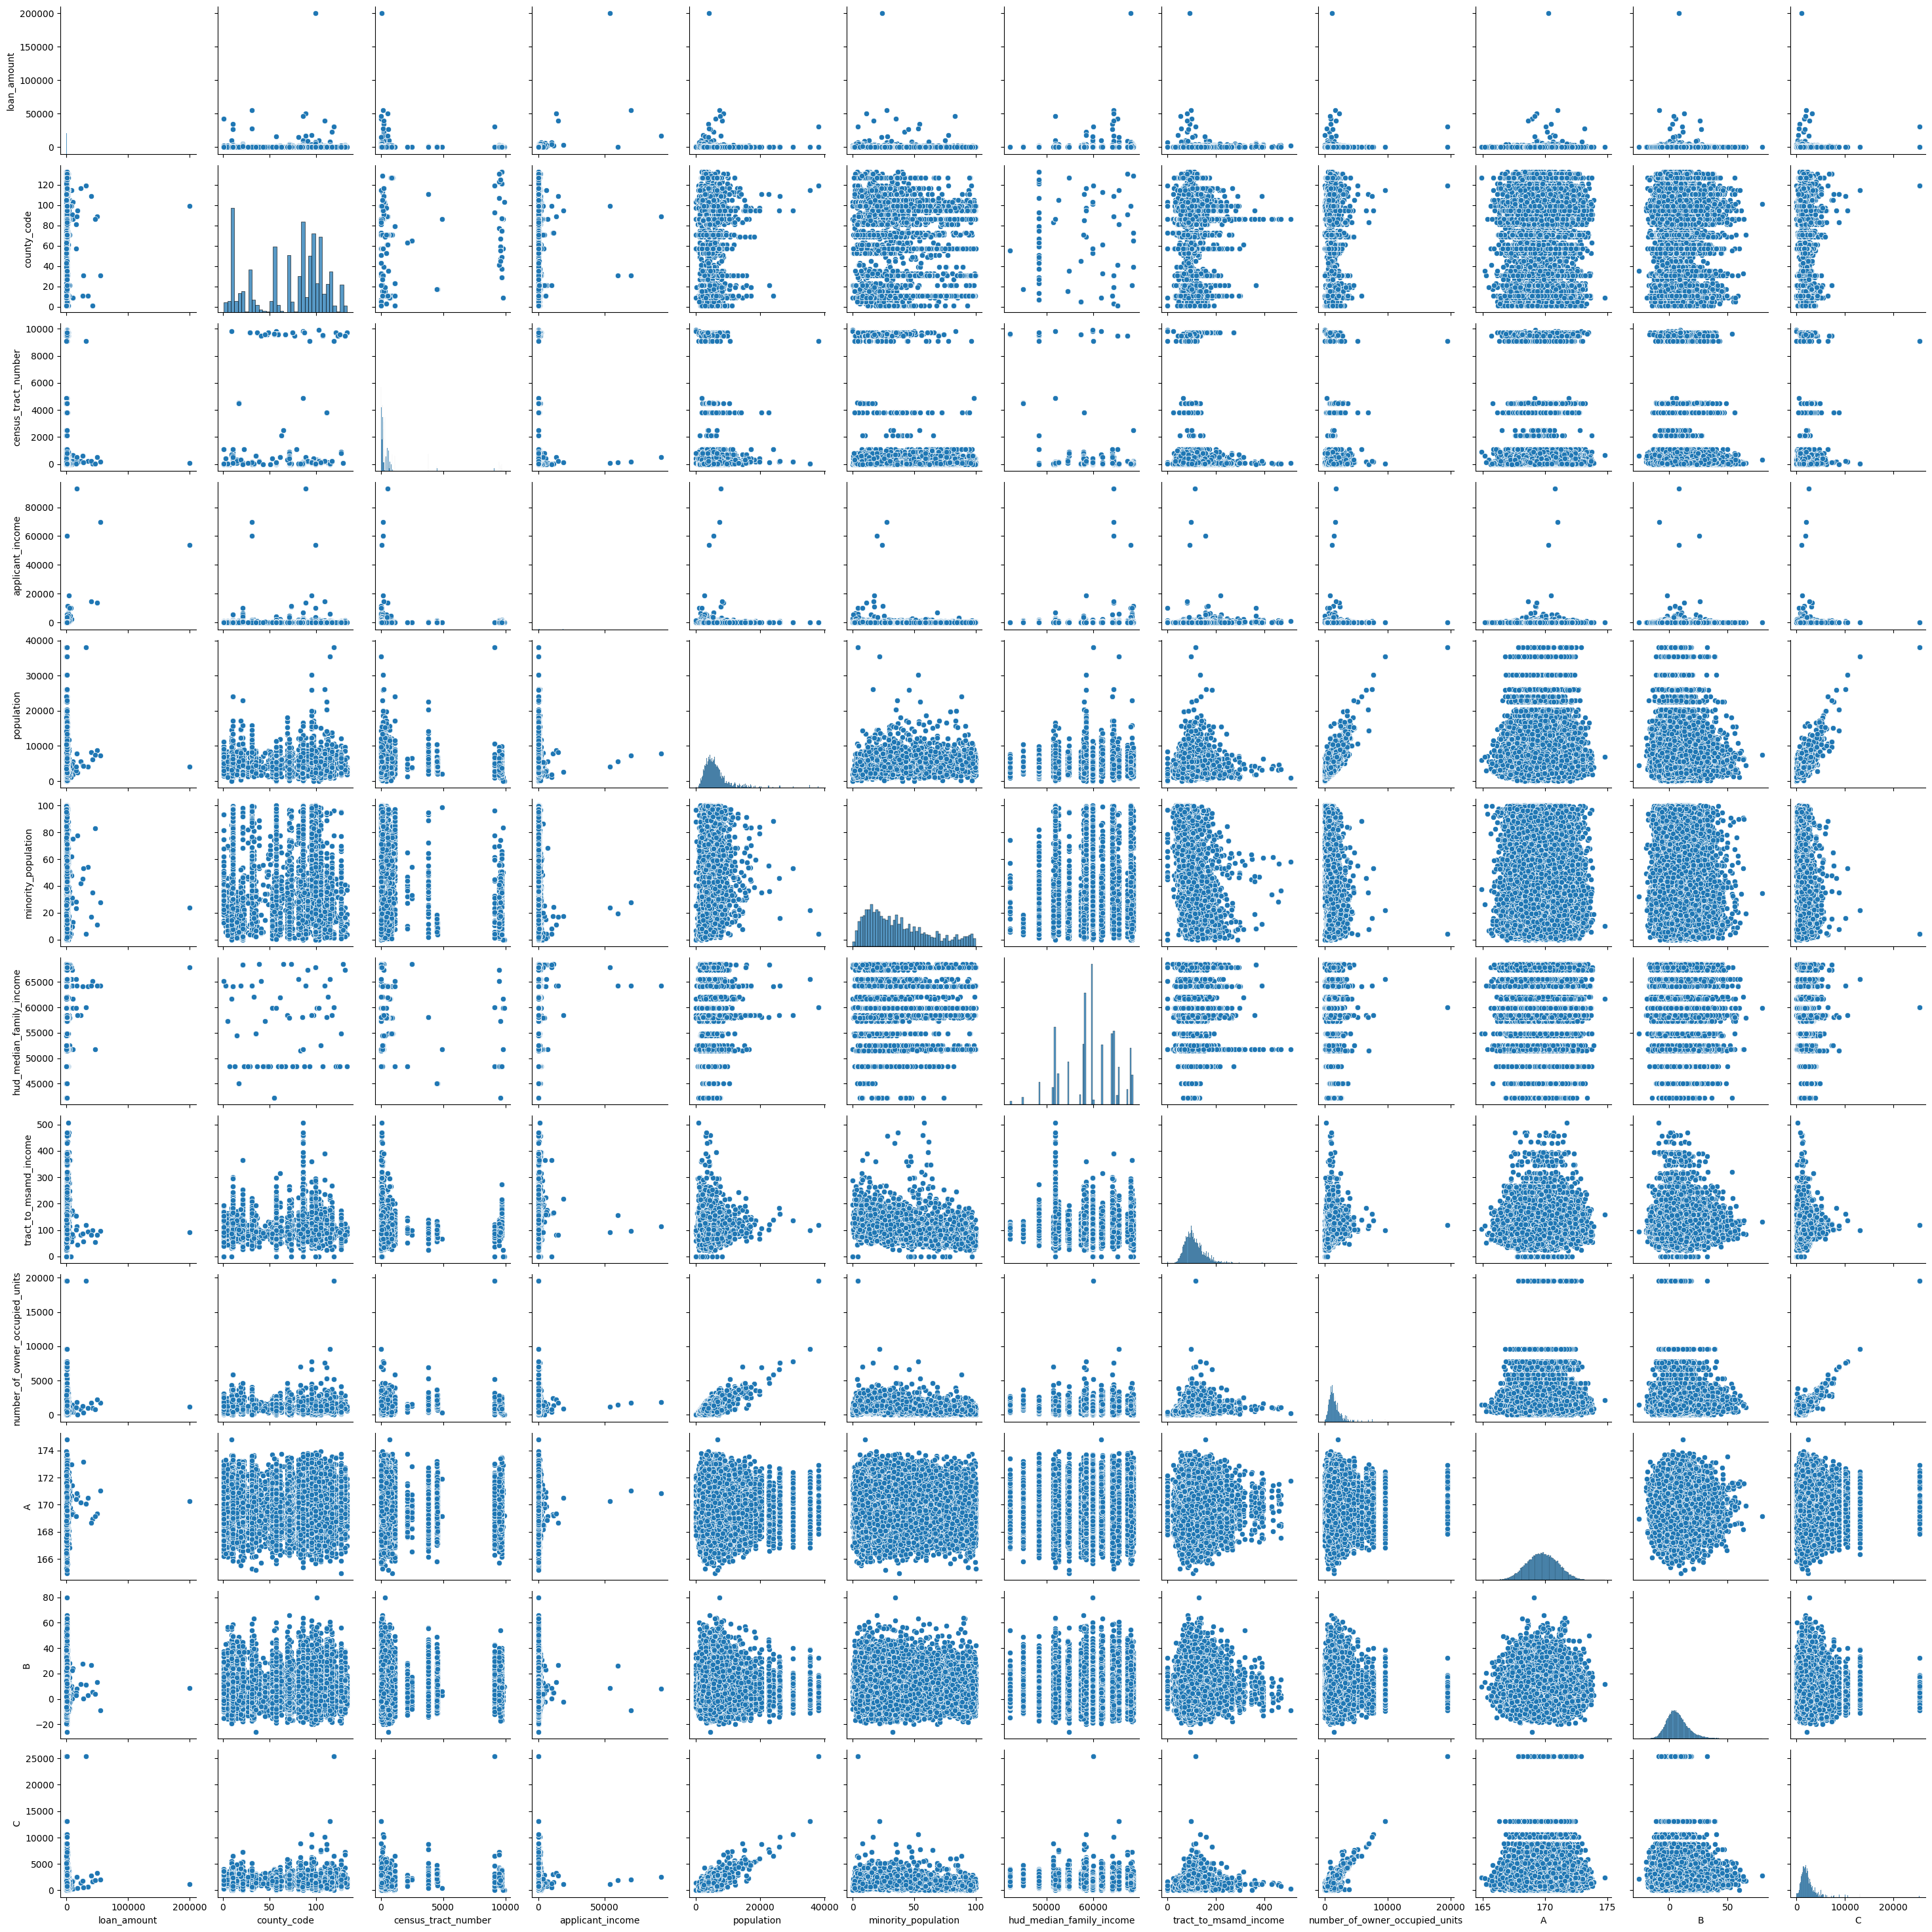



Relationships between features heatmap




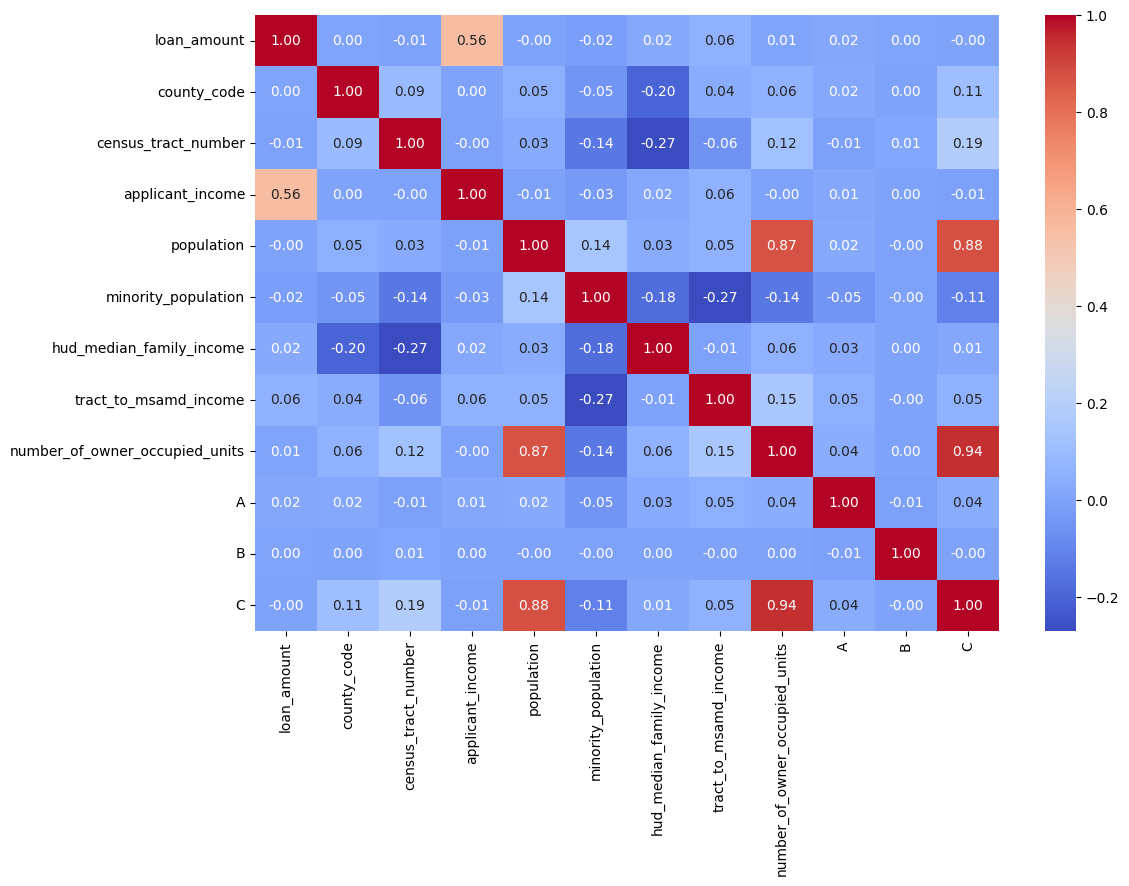

agency
Department of Housing and Urban Development    24450
Consumer Financial Protection Bureau           13173
National Credit Union Administration            2983
Federal Deposit Insurance Corporation           1812
Office of the Comptroller of the Currency       1297
Federal Reserve System                           651
Name: count, dtype: int64
loan_type
Conventional          31581
FHA-insured            7603
VA-guaranteed          4615
FSA/RHS-guaranteed      315
Name: count, dtype: int64
property_type
One-to-four family dwelling (other than manufactured housing)    42997
Manufactured housing                                              2459
Multifamily dwelling                                                67
Name: count, dtype: int64
loan_purpose
Home purchase       23114
Refinancing         15348
Home improvement     5436
Name: count, dtype: int64
owner_occupancy
Owner-occupied as a principal dwelling        38649
Not owner-occupied as a principal dwelling     5435
Not applica

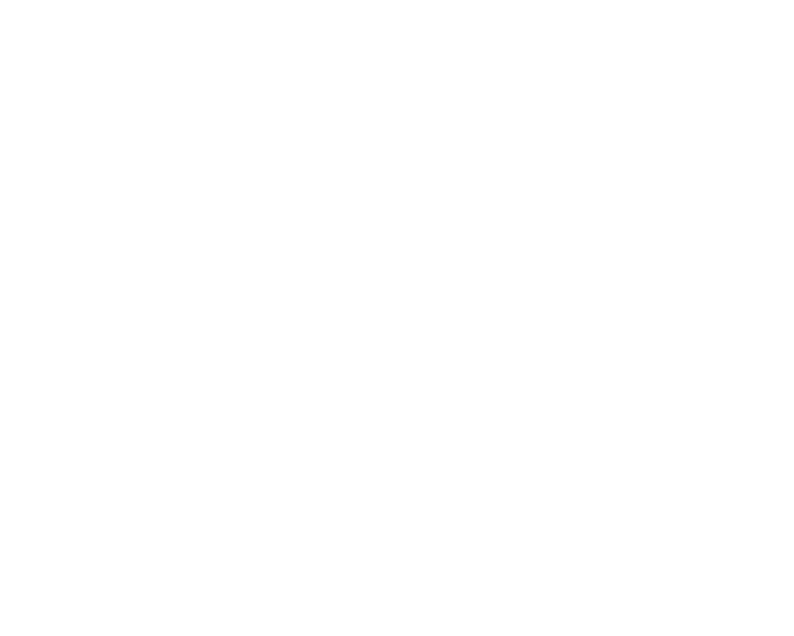

In [3]:
columns_to_exclude = ['ID', 'label']  #  Label and ID excluded for exploration

# Drop the specified columns for exploration
data_without_id_label_cols = data.drop(columns=columns_to_exclude)
data_for_exploration = data_without_id_label_cols

# Seperate numeric and categorical columns for exploration
all_cols = data_for_exploration.columns
numeric_cols = data_for_exploration.select_dtypes(include=np.number).columns
numeric_data = data_for_exploration[numeric_cols]
categorical_cols= list(set(all_cols) - set(numeric_cols))

#Head
print("\n\nHead of data:\n\n", data_for_exploration.head())

#Shape
print("\n\nShape of data:\n\n", data_for_exploration.shape)

# Statistics
print("\n\nStatistics of data:\n\n", data_for_exploration.describe())
print("\n\nGraphs:\n\n")

# Graphs
# Histogram
print("\n\nHistogram of data:\n\n")
data_for_exploration.hist(figsize=(15, 10)) #bins=30
plt.show()

# Check outliers
print("\n\nBoxplots of data:\n\n")
for col in data_for_exploration.select_dtypes(include=['number']).columns:
    sns.boxplot(data_for_exploration[col])
    plt.show()

# Relationships between features
print("\n\nRelationships between features:\n\n")
sns.pairplot(data_for_exploration)
plt.show()

# Relationships between features in a heatmap
print("\n\nRelationships between features heatmap\n\n")
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

text_data = data_for_exploration['county']

# Value counts for each column
for col in data_for_exploration.select_dtypes(include=['object']).columns:
    print(data_for_exploration[col].value_counts())

plt.figure(figsize=(10,8))
#plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Visualization and Categorical data analysis

We started by making visualizations mainly for numerical variables because the exploration phase came before treating categorical variables.

Based on the results of numerical statistics, histograms, and the correlation heatmap, along with categorical value counts, we can conclude that the dataset is marked by significant missing values and heavy right-skewness with prominent outliers in key financial features like loan_amount and applicant_income.

While some features exhibit multimodal distributions (e.g., county_code, minority_population), indicating diverse underlying segments, strong positive correlations are evident between population, number_of_owner_occupied_units, and feature 'C', suggesting their interconnectedness.

Surprisingly, the linear relationship between loan_amount and applicant_income appears weak, hinting at more complex or non-linear dynamics - Something that we would like to check later in our models. Furthermore, categorical data reveals dominant categories and a strong geographical focus on Florida, along with notable gaps in reported demographic information.

Collectively, these insights underscore the critical need for extensive data preprocessing, including handling missing values, outlier treatment, and data transformations before any robust modeling can be performed.

# 2. Preprocessing

# a) Handling Missing values
- There are missing values in the data. For categorical columns, missing values are filled with the most frequent value.
For numerical columns, missing values are filled with the mean. Standard ways of dealing with them.

In [ ]:
# Define a function to handle missing values
def handle_missing_data(df):
    # Seperate numeric and categorical columns based on the input DataFrame 'df'
    numeric_cols = df.select_dtypes(include=np.number).columns.drop('ID', errors='ignore').tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if col in categorical_cols:
                # For categorical data, fill with mode
                df[col].fillna(df[col].mode()[0], inplace=True)
            elif col in numeric_cols:
                # For numerical data, fill with mean
                df[col].fillna(df[col].mean(), inplace=True)
    return df

# Handling missing data
data = handle_missing_data(data)

# b) Dropping Columns That Don't Provide Value
Columns that have 95%+ same values wont provide much value to the model, so we will drop these

In [ ]:
# Identify categorical columns
def drop_useless_cols(data):
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    cols_to_drop = ["census_tract_number", "county_code"] # A categorical value disguised as numeric, id codes of geographic areas - no value added
    # Drop all columns that have 95%+ same value as they wont affect label
    for col in categorical_cols:
        top_freq = data[col].value_counts(normalize=True).max()
        if top_freq > 0.95:
            cols_to_drop.append(col)
            print(f"{col}: {top_freq*100:.2f}% same value")

    data_dropped = data.drop(cols_to_drop, axis=1)
    return data_dropped

data = drop_useless_cols(data)

all_cols = data.columns
numeric_cols = [col for col in data.select_dtypes(include=np.number).columns if col != 'label']
numeric_data = data[numeric_cols]
categorical_cols= list(set(all_cols) - set(numeric_cols))

# Test which categorical columns remain
# categorical_cols = data.select_dtypes(include=['object', 'category']).columns
# print(categorical_cols)

applicant_race_name_2: 99.80% same value
applicant_race_name_3: 99.98% same value
co_applicant_race_name_2: 99.95% same value
co_applicant_race_name_3: 100.00% same value


# c) Outliers
We'll use box plots for to visually identify outliers in columns.
We've noticed that there are outliers and we're going to identify them and remove them.
Some identified as outliers by the conventional way of thresholds +-1.5*IQR are valid data and so we will increase the thresholds for outliers to include them in the data, such as in the applicant_income column.

Log-transform highly skewed but legitimate numeric variables 'applicant_income', 'loan_amount' - this is a mathematical manipulation to help squeeze the data in a more manageable interval


In [ ]:
def deal_with_outliers(data):
    # Log-transform highly skewed but legitimate numeric variables
    for col in ['applicant_income', 'loan_amount']:
        if col in data.columns:
            data[col] = np.log1p(data[col])

    # Identifying outliers for each numerical column
    def identify_outliers(data, columns):
        outliers = pd.DataFrame()
        for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound))
        return outliers

    def identify_outliers_special(data, columns):
        outliers = pd.DataFrame()
        for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 5 * IQR
            upper_bound = Q3 + 5 * IQR
            outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound))
        return outliers

    # Remove these outliers
    def remove_outliers(data, outliers):
        # Combined row-wise mask: True if outlier in ANY column
        combined_mask = outliers.any(axis=1)
        return data[~combined_mask]

    special_outlier_cols = ['B', 'tract_to_msamd_income', 'population', 'number_of_owner_occupied_units', 'applicant_income', 'loan_amount']
    regular_outlier_cols = [col for col in numeric_cols if col not in special_outlier_cols]
    regular_outliers = identify_outliers(data, regular_outlier_cols)
    special_outliers = identify_outliers_special(data, special_outlier_cols)
    data_no_regular_outliers = remove_outliers(data.copy(), regular_outliers)
    data_no_outliers = remove_outliers(data_no_regular_outliers.copy(), special_outliers)
    return data_no_outliers


print(data.shape) # Print shape before and after dealing with outliers to check how many were removed
data = deal_with_outliers(data)
print(data.shape)

(293664, 28)
(260252, 28)


# d) Categorical variables
 These need to be processed in a way that can be provided to machine learning algorithms. We have a few options:
Label Encoding: Converts categorical values into numerical labels. Useful for ordinal variables where the order matters.
One-Hot Encoding: Creates binary columns for each category. Useful for nominal variables where the order doesn't matter.

We will use One-Hot Encoding: Creates binary columns for each category. Useful for nominal variables where the order doesn't matter.

Our categorical variables are: county, msamd, co_applicant_race_name_1,
applicant_race_name_1, D, agency, co_applicant_ethnicity,co_applicant_sex, loan_type, applicant_ethnicity, applicant_sex, loan_purpose, owner_occupancy,
preapproval, property_type, lien_status

In [ ]:
# For testing: Check how many values are in each categorical col before handling them
# categorical_cols = data.select_dtypes(include=['object', 'category']).columns
# unique_counts_categorical = data[categorical_cols].nunique().sort_values(ascending=False)
# print(unique_counts_categorical)

def handle_categorical_variables(data):
    # numeric_cols = data.select_dtypes(include=np.number).columns
    # Use sparse=False if you want a dense array output
    categorical_cols_for_test_set = [col for col in categorical_cols if col != "label"]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_array = encoder.fit_transform(data[categorical_cols_for_test_set])
    numerical_transformer = StandardScaler()

    encoded_df = pd.DataFrame(
        encoded_array,
        columns=encoder.get_feature_names_out(categorical_cols_for_test_set),
        index=data.index  # keep row alignment
    )
    # Drop the original categorical columns
    if 'label' in data.columns: # TRAIN SET
        label_col_to_save_at_the_end = data['label']
        data_non_cat = data.drop(columns=categorical_cols)
        # data_non_cat = data_non_cat.drop('label', axis=1)
        # Combine with the encoded columns
        processed_data = pd.concat([data_non_cat, encoded_df], axis=1)
        processed_data_with_label = pd.concat( [processed_data, label_col_to_save_at_the_end] , axis = 1)
        return processed_data_with_label
    else: # TEST SET
        data_non_cat = data.drop(columns=categorical_cols_for_test_set)
        # Combine with the encoded columns
        processed_data = pd.concat([data_non_cat, encoded_df], axis=1)
        return processed_data

data = handle_categorical_variables(data)

# e) Normalization
First we check for normalization by examining the range and distribution of the numerical columns.
The data is not normalized, so we will apply a standard transformation.
The importance of normaliztion here is that it enables us to compare and correlate features, being on the same scale from 0 to 1.

In [ ]:
# Normalization
def data_normalization(data):
    # Checking the range of numerical columns
    data_ranges = data[numeric_cols].describe().loc[['min', 'max']]
    print("Ranges of numerical columns before normalization:")
    print(data_ranges)
    print("Data needs normalization. Applying min-max scaling...")
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    data_ranges = data[numeric_cols].describe().loc[['min', 'max']]
    print("\n\nRanges of numerical columns after normalization:")
    print(data_ranges)
    return data

data = data_normalization(data)

Ranges of numerical columns before normalization:
           ID  loan_amount  applicant_income  population  minority_population  \
min       0.0     0.693147          0.693147         0.0                  0.0   
max  665533.0     9.878221          8.521185     24009.0                100.0   

     hud_median_family_income  tract_to_msamd_income  \
min                   51500.0               0.000000   
max                   68500.0             348.179993   

     number_of_owner_occupied_units           A          B       C  
min                             0.0  166.596993 -26.239378     0.0  
max                          5895.0  172.995013  63.131495  4722.0  
Data needs normalization. Applying min-max scaling...


Ranges of numerical columns after normalization:
           ID  loan_amount  applicant_income  population  minority_population  \
min -1.913449    -4.051307         -5.087858   -2.227496            -1.499555   
max  1.559437     4.769553          5.960692    7.077029       

# f) Applying PCA to reduce dimensionality
 High dimensionality in a dataset can create problems, such as overfitting (high-dimensional data can lead to models that capture noise instead of the underlying pattern, causing poor generalization to new data), increased computational cost (more dimensions require more computational resources for training and inference) , sparse data (higher probability of a row that's not full).
- Our dimensionality here is indeed too high as we can get very close accuracy after reducing from 166 variables to 47 using PCA
- Reducing the number of variables will improve performance

In [ ]:
train_ids = data['ID'].to_numpy()
data = data.drop(columns=["ID"])

#These 3 lines are only for the train set
X_train = data.to_numpy()
X_train = X_train[:, :-1]
y = data['label'].to_numpy()

# PCA, Retain 95% of the variance
pca = PCA(n_components=0.95) # pca will be a global variable so that it can be used for both the train and test set
pca.fit(X_train)

def apply_pca(X):
    # Dimensionality
    # Check the number of features
    num_features = X.shape[1]
    print(f"Original shape: {X.shape}")
    print(f"Number of features: {num_features}")

    X_pca_applied = pca.transform(X)

    # Check the shape of the data after PCA
    #print(f"Original shape: {X_train_scaled.shape}")
    print(f"Reduced shape: {X_pca_applied.shape}")
    print(f"Reduced number of features after PCA: {X_pca_applied.shape[1]}")
    return X_pca_applied

X_train_processed = apply_pca(X_train) # Apply PCA on train set

Original shape: (260252, 166)
Number of features: 166
Reduced shape: (260252, 47)
Reduced number of features after PCA: 47


# g) Preprocessing on test set
Apply all the preprocessing functions on the test set

In [ ]:
# Preprocessing function to be applied to the test set
train_cols_after_preprocessing = data.columns.drop('label')

def preprocess_test_set(test_data):
    # Calls all previously built prepocessing functions
    test_data = handle_missing_data(test_data)
    test_data = drop_useless_cols(test_data)
    test_data = deal_with_outliers(test_data)

    # Save test ID column for predictions
    test_ids = test_data['ID'].copy()

    # Testing difference in categoricals
    test_categorical_cols = test_data.select_dtypes(include=['object', 'category']).columns
    unique_counts_categorical = test_data[test_categorical_cols].nunique().sort_values(ascending=False)

    test_data = handle_categorical_variables(test_data)
    test_data = data_normalization(test_data)

    # Align columns with the training set after preprocessing
    test_data = test_data.reindex(columns=train_cols_after_preprocessing, fill_value=0)

    # Convert the DataFrame to a NumPy array
    X_test = test_data.to_numpy()
    # Apply PCA to test set
    X_test = apply_pca(X_test)
    return X_test, test_ids

test_data = pd.read_csv('test.csv')
X_test, test_ids = preprocess_test_set(test_data) # Apply preprocessing on test set

applicant_race_name_2: 99.80% same value
applicant_race_name_3: 99.98% same value
co_applicant_race_name_2: 99.96% same value
co_applicant_race_name_3: 99.99% same value
Ranges of numerical columns before normalization:
           ID  loan_amount  applicant_income  population  minority_population  \
min       4.0     0.693147          0.693147         0.0                  0.0   
max  665532.0     9.649949          8.630700     24009.0                100.0   

     hud_median_family_income  tract_to_msamd_income  \
min                   51500.0               0.000000   
max                   68500.0             348.179993   

     number_of_owner_occupied_units           A          B       C  
min                             0.0  166.625757 -21.606823     0.0  
max                          5895.0  172.969719  62.795577  4722.0  
Data needs normalization. Applying min-max scaling...


Ranges of numerical columns after normalization:
           ID  loan_amount  applicant_income  populatio

# 3. Models

# a) Logistic Regression
Hyperparamaters are:
- random_state = 42 - doesn't affect model performance much, we set it to a fixed value to ensure reproducibility.

- max_iter = 1000 -  Our dataset is very large and sometimes the default 100 isn't enough and the model fails to converge. We increased it to 1000 to make sure the optimization process has enough steps to find a good solution.

- Default 'tol' values of 0.0001 are good enough - Training stops when the improvement in the loss function is smaller than this value. The default usually works well.

In [ ]:
# Logistic Regression
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_processed, y, test_size=len(X_test), random_state=42)

log_reg_model = LogisticRegression(random_state=42)

# Train the model on the training data
log_reg_model.fit(X_train, y_train)

#Predict on the validation set
y_val_pred = log_reg_model.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.5f}")

# Predict probabilities for the validation set
y_val_prob = log_reg_model.predict_proba(X_val)[:, 1]

# Calculate the AUC score
auc_log = roc_auc_score(y_val, y_val_prob)
print(f"AUC Score: {auc_log:.5f}")

# Generate a classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.78277
AUC Score: 0.86613
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78     23097
           1       0.78      0.79      0.78     23020

    accuracy                           0.78     46117
   macro avg       0.78      0.78      0.78     46117
weighted avg       0.78      0.78      0.78     46117

Confusion Matrix:
[[17952  5145]
 [ 4873 18147]]


# b) K-NN
Hyperparamaters are:
- Neighbors = 7, gave us a good balance of not sacrificing accuracy much
- algorithm = 'auto' chooses the best one
- weights = 'uniform' by default

In [ ]:
# KNN
# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_knn = knn_model.predict(X_val)
y_val_prob_knn = knn_model.predict_proba(X_val)[:, 1]

# Evaluate K-Nearest Neighbors
accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
auc_knn = roc_auc_score(y_val, y_val_prob_knn)
print(f"KNN - Accuracy: {accuracy_knn:.5f}, AUC: {auc_knn:.5f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_knn))

KNN - Accuracy: 0.74441, AUC: 0.81778
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73     23097
           1       0.72      0.79      0.75     23020

    accuracy                           0.74     46117
   macro avg       0.75      0.74      0.74     46117
weighted avg       0.75      0.74      0.74     46117

Confusion Matrix:
[[16219  6878]
 [ 4909 18111]]


# c) Random forest
Hyperparametrs:
- random_state = 42 - we pick a random number
- n_estimator = 50 - cut down on time
- max_depth - limit tree growth.
- max_depth = default
n_jobs = -1 - use all CPU cores

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_prob_rf = rf_model.predict_proba(X_val)[:, 1]

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
auc_rf = roc_auc_score(y_val, y_val_prob_rf)
print(f"Random Forest - Accuracy: {accuracy_rf:.5f}, AUC: {auc_rf:.5f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))

Random Forest - Accuracy: 0.77277, AUC: 0.85399
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     23097
           1       0.77      0.78      0.78     23020

    accuracy                           0.77     46117
   macro avg       0.77      0.77      0.77     46117
weighted avg       0.77      0.77      0.77     46117

Confusion Matrix:
[[17587  5510]
 [ 4969 18051]]


# d) MLP



In [ ]:
mlp_model = Pipeline([
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,),      # simpler architecture
                          activation='relu',
                          solver='adam',
                          max_iter=100,                   # fewer iterations
                          early_stopping=True,            # stops when validation loss stops improving
                          n_iter_no_change=5,             # patience for early stopping
                          random_state=42))
])

# Evaluate
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_val)
y_prob = mlp_model.predict_proba(X_val)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("AUC Score:", roc_auc_score(y_val, y_prob))

Confusion Matrix:
 [[18013  5084]
 [ 4615 18405]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     23097
           1       0.78      0.80      0.79     23020

    accuracy                           0.79     46117
   macro avg       0.79      0.79      0.79     46117
weighted avg       0.79      0.79      0.79     46117

AUC Score: 0.8721106716218575


# 4. Model Evaluation

# a) Confusion Matrix
We're getting good amount of True positive and negatives, the model is working well.
Top left is TN and bottom right is TP.

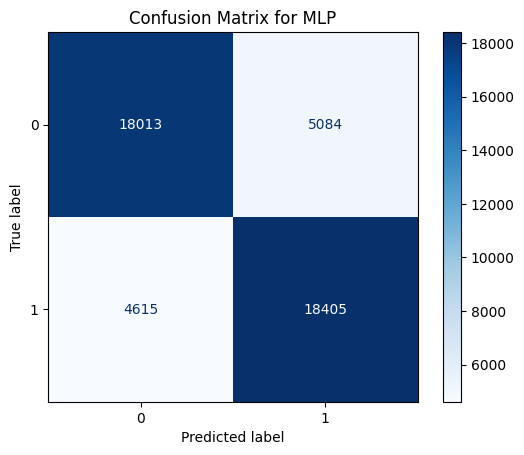

Confusion Matrix:
 [[18013  5084]
 [ 4615 18405]]


In [ ]:
# Predicting the test set results
y_pred = mlp_model.predict(X_val)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg_model.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix for MLP")
plt.show()

# Printing the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# b) Cross Fold-K Validation
Building an ROC output on each Fold-K for each of the models run


Running Logistic Regression


Running KNN


Running Random Forest


Running MLP



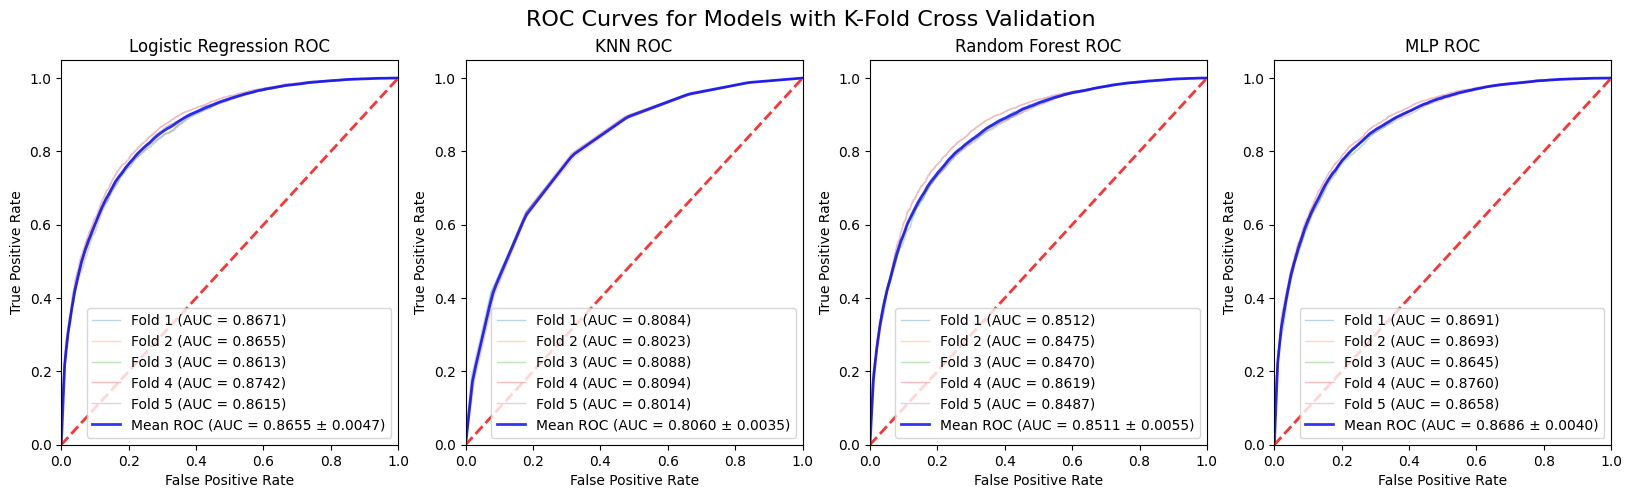

In [ ]:
# Number of splits for K-Fold
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize plots
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

models = {
    'Logistic Regression': log_reg_model,
    'KNN': knn_model,
    'Random Forest': rf_model,
    'MLP': mlp_model
}

# Loop over each model
for i, (model_name, model) in enumerate(models.items()):
    print(f"\nRunning {model_name}\n")
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X_val , y_val)):
        X_train_fold, X_test_fold = X_val[train_index], X_val[test_index]
        y_train_fold, y_test_fold = y_val[train_index], y_val[test_index]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Get the probability estimates for the positive class
        y_prob = model.predict_proba(X_test_fold)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
        roc_auc = auc(fpr, tpr)

        # Interpolate the ROC curve to get a mean curve across folds
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)

        # Plot ROC curve for the current fold
        ax[i].plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold + 1} (AUC = {roc_auc:.4f})')

    # Plot the mean ROC curve across folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[i].plot(mean_fpr, mean_tpr, color='b',
               label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
               lw=2, alpha=0.8)

    # Plot the chance line (diagonal)
    ax[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title(f'{model_name} ROC')
    ax[i].legend(loc='lower right')

plt.suptitle('ROC Curves for Models with K-Fold Cross Validation', fontsize=16)
plt.show()

# c) Performance gaps between running the model on the Train and the Validation set
Our validated AUC is 0.8686 which means that our model handles new data well and isn't overfitted. The train AUC is 0.8721 which is slightly better but the margin isn't substantial. We did not observe significant performance gaps between the model's results on the training data and the validation data. Precision/recall values were balanced across folds. This suggests that the model is not overfitted it generalizes well to unseen data and does not simply memorize the training set.


HOW TO IMPROVE MLP MODEL: Increase max_iter if training isn't converging

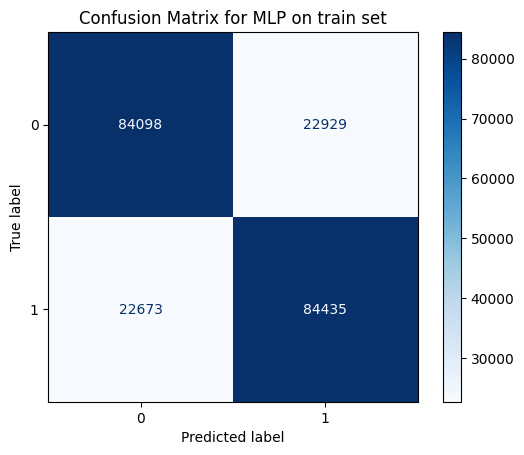

Confusion Matrix:
 [[84098 22929]
 [22673 84435]]
MLP Training Accuracy On Training Set: 0.78704
Performance on Original Data
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     23097
           1       0.78      0.80      0.79     23020

    accuracy                           0.79     46117
   macro avg       0.79      0.79      0.79     46117
weighted avg       0.79      0.79      0.79     46117

MLP Training Accuracy On Validation Set: 0.78969



Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     23097
           1       0.78      0.80      0.79     23020

    accuracy                           0.79     46117
   macro avg       0.79      0.79      0.79     46117
weighted avg       0.79      0.79      0.79     46117

Confusion Matrix:
[[18013  5084]
 [ 4615 18405]]


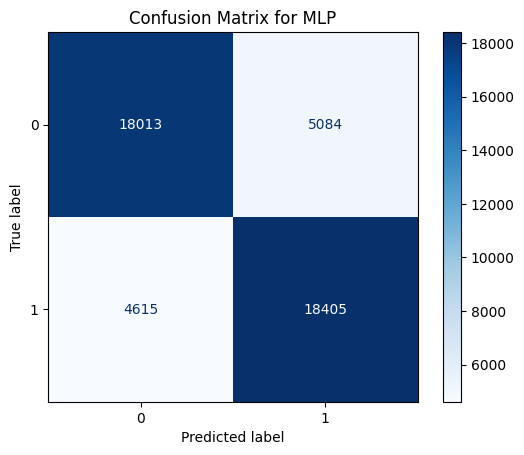

In [ ]:
# Predicting the train set results
y_pred_mlp_train = mlp_model.predict(X_train)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred_mlp_train)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=mlp_model.classes_)
disp1.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix for MLP on train set")
plt.show()

# Printing the confusion matrix
print("Confusion Matrix:\n", conf_matrix)
accuracy_mlp_train = accuracy_score(y_train , y_pred_mlp_train)
print(f"MLP Training Accuracy On Training Set: {accuracy_mlp_train:.5f}")

# Vaildation Set
validation_mlp_model = Pipeline([
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,),      # simpler architecture
                          activation='relu',
                          solver='adam',
                          max_iter=300,
                          early_stopping=True,            # stops when validation loss stops improving
                          n_iter_no_change=5,             # patience for early stopping
                          random_state=42))
])

validation_mlp_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = validation_mlp_model.predict(X_val)

print("Performance on Original Data")
print(classification_report(y_val, y_pred_val))
print(f"MLP Training Accuracy On Validation Set: {accuracy_score(y_val, y_pred_val):.5f}\n\n\n")

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_val, y_pred_val)
print("Classification Report:")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=validation_mlp_model.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix for MLP")
plt.show()

# 5. Predictions

In [ ]:
#Predict using MLP
y_pred_mlp = mlp_model.predict(X_test)

# # Predict using K-NN
# y_pred_knn = knn_model.predict(X_test)

# # Predict using Random Forest
# y_pred_rf = rf_model.predict(X_test)

# # Predict using Logistic Regression
# y_pred_logistic = log_reg_model.predict(X_test)


# Save predictions to a CSV file
predictions = pd.DataFrame({
    'ID': test_ids,
    'TARGET': y_pred_mlp
    # 'K-NN': y_pred_knn,
    # 'Random_Forest': y_pred_rf,
    # 'AdaBoost': y_pred_adaboost
})

predictions.to_csv('test_predictions.csv', index=False)

# Predict probabilities using MLP
prob_mlp = mlp_model.predict_proba(X_test)
prob_mlp = prob_mlp[:, 1]


# # Predict probabilities using K-NN (Note: Ensure K-NN is set up to return probabilities)
# prob_knn = knn_model.predict_proba(X_test)

# # Predict probabilities using Random Forest
# prob_rf = rf_model.predict_proba(X_test)

# # Predict probabilities using AdaBoost
# prob_adaboost = ada_model.predict_proba(X_test)

# Assuming the positive class is the second column (index 1)
# prob_knn_pos = prob_knn[:, 1]
# prob_rf_pos = prob_rf[:, 1]
# prob_adaboost_pos = prob_adaboost[:, 1]

# Create a DataFrame with the probabilities
probabilities = pd.DataFrame({
    'ID': test_ids,
    'TARGET': prob_mlp
    # 'K-NN_Pos_Class': prob_knn_pos,
    # 'Random_Forest_Pos_Class': prob_rf_pos,
    # 'AdaBoost_Pos_Class': prob_adaboost_pos
})

# Save to CSV
probabilities.to_csv('test_probabilities.csv', index=False)

# 6. Extra tool used
We used the Seaborn Library to visualize relationships between features and look for certain correlations.
Using this Library helped us recognize different patterns some that gave new insight about the 'C' feature and some that raised questions.

# Pipeline

applicant_race_name_2: 99.80% same value
applicant_race_name_3: 99.98% same value
co_applicant_race_name_2: 99.95% same value
co_applicant_race_name_3: 100.00% same value
Ranges of numerical columns before normalization:
           ID  loan_amount  applicant_income  population  minority_population  \
min       0.0     0.693147          0.693147         0.0                  0.0   
max  665533.0     9.878221          8.521185     24009.0                100.0   

     hud_median_family_income  tract_to_msamd_income  \
min                   51500.0               0.000000   
max                   68500.0             348.179993   

     number_of_owner_occupied_units           A          B       C  
min                             0.0  166.596993 -26.239378     0.0  
max                          5895.0  172.995013  63.131495  4722.0  
Data needs normalization. Applying min-max scaling...


Ranges of numerical columns after normalization:
           ID  loan_amount  applicant_income  populati

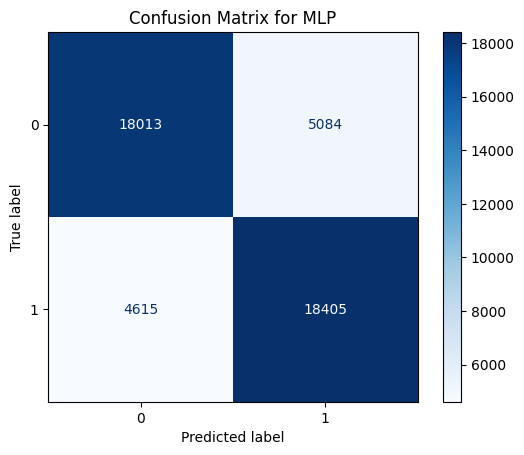

Confusion Matrix:
 [[18013  5084]
 [ 4615 18405]]

Running Logistic Regression


Running KNN


Running Random Forest


Running MLP



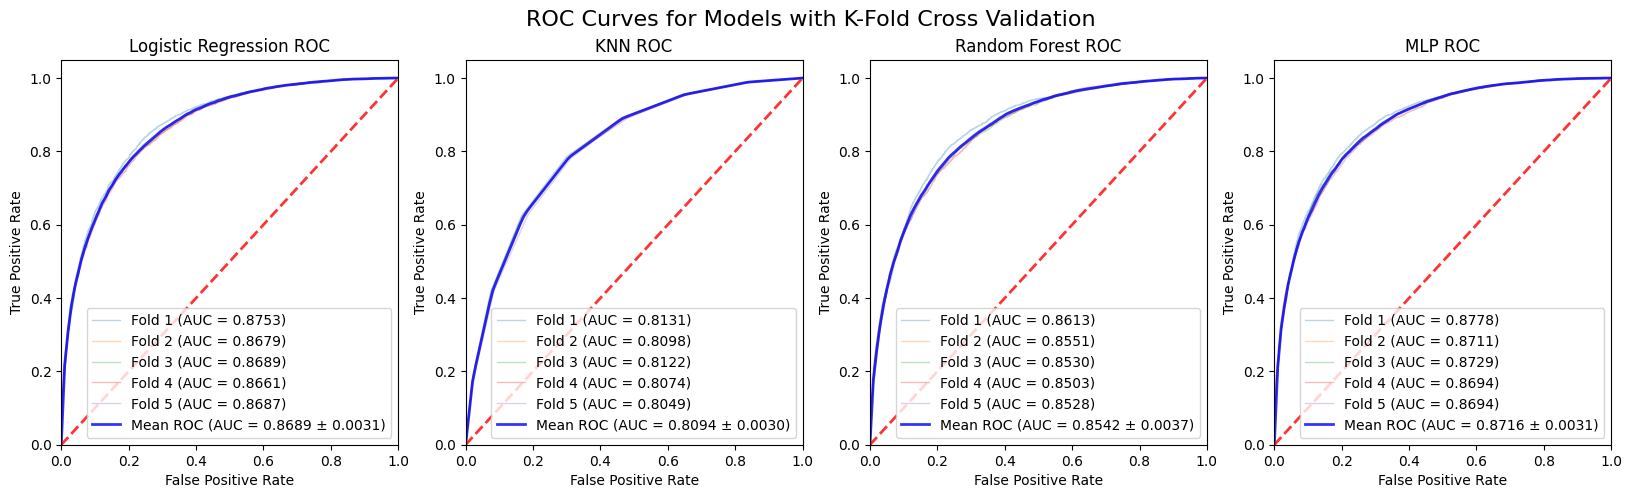

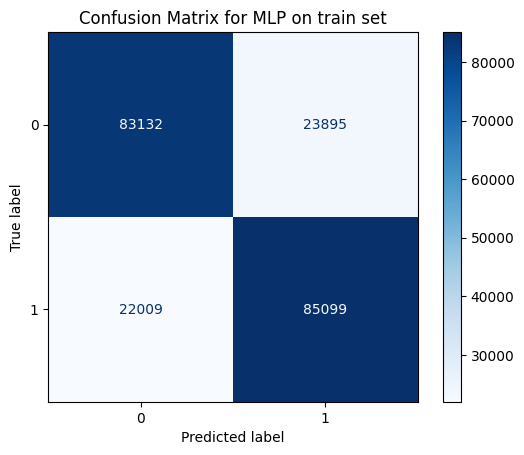

Confusion Matrix:
 [[83132 23895]
 [22009 85099]]
MLP Training Accuracy On Training Set: 0.78563
Performance on Original Data
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     23097
           1       0.78      0.80      0.79     23020

    accuracy                           0.79     46117
   macro avg       0.79      0.79      0.79     46117
weighted avg       0.79      0.79      0.79     46117

MLP Training Accuracy On Validation Set: 0.78969



Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     23097
           1       0.78      0.80      0.79     23020

    accuracy                           0.79     46117
   macro avg       0.79      0.79      0.79     46117
weighted avg       0.79      0.79      0.79     46117

Confusion Matrix:
[[18013  5084]
 [ 4615 18405]]


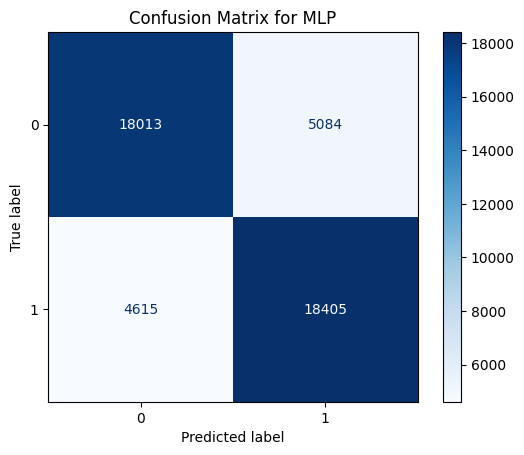

Done with Preprocessing and Model Training, ready for Predictions

Done with Preprocessing, Model Training and Predictions


In [ ]:
# Pipeline
def pipeline(train_data_path, new_data_path):
    # read the train data
    train_data = pd.read_csv(train_data_path)
    # read the test data
    new_data = pd.read_csv(new_data_path)

    all_cols = train_data.columns
    columns_to_exclude_train = ['ID', 'label']  # columns to exclude from train set
    #columns_to_exclude_new = ['ID']  # columns to exclude from new set
    # Drop the specified columns
    data_filtered_train = train_data.drop(columns=columns_to_exclude_train)
    #data_filtered_test = new_data.drop(columns=columns_to_exclude_test)

    # # Apply preprocessing on train data set
    train_data = handle_missing_data(train_data) #handling missing data
    train_data = drop_useless_cols(train_data)
    train_data = deal_with_outliers(train_data) #dealing wiht outliers
    train_data = handle_categorical_variables(train_data)  #handling categorical variables
    train_data = data_normalization(train_data)  # Normalize

    # Apply preprocessing and PCA on new data set
    X_new, X_new_ids = preprocess_test_set(new_data)

    train_ids = train_data['ID'].to_numpy()
    train_data = train_data.drop(columns=["ID"])

    # Turn data into numpy
    X = train_data.to_numpy()
    X = X[:, :-1]
    y = train_data['label'].to_numpy()

    #np.savetxt("pipeline_X.csv", X, delimiter=",", fmt="%.2f")  # You can change fmt to "%.0f" if you want integers

    # Apply PCA to train set, new set has already undergone PCA in the preprocess_test_set function
    X = apply_pca(X)

    print("Done with Preprocessing and ready for Model Training and Predictions")

    # # # MODEL Training
    # # Logistic Regression
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=len(X_new), random_state=42)

    mlp_model = Pipeline([
        ('mlp', MLPClassifier(hidden_layer_sizes=(50,),      # simpler architecture
                            activation='relu',
                            solver='adam',
                            max_iter=100,                   # fewer iterations
                            early_stopping=True,            # stops when validation loss stops improving
                            n_iter_no_change=5,             # patience for early stopping
                            random_state=42))
    ])

    # Train the model on the training data
    mlp_model.fit(X_train, y_train)

    #Predict on the validation set
    y_val_pred = mlp_model.predict(X_val)

    # Calculate the accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Accuracy: {accuracy:.5f}")

    # Predict probabilities for the validation set
    y_val_prob = mlp_model.predict_proba(X_val)[:, 1]

    # Calculate the AUC score
    auc_log = roc_auc_score(y_val, y_val_prob)
    print(f"AUC Score: {auc_log:.5f}")

    # Generate a classification report
    report = classification_report(y_val, y_val_pred)
    print("Classification Report:")
    print(report)

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # # # Model Evaluation
    # # Confution matrix
    # Predicting the test set results
    y_pred = mlp_model.predict(X_val)

    # Creating the confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=mlp_model.classes_)
    disp.plot(cmap = plt.cm.Blues)
    plt.title("Confusion Matrix for MLP")
    plt.show()

    # Printing the confusion matrix
    print("Confusion Matrix:\n", conf_matrix)

    # # Cross Fold-K Validation
    # Number of splits for K-Fold
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize plots
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    models = {
        'Logistic Regression': log_reg_model,
        'KNN': knn_model,
        'Random Forest': rf_model,
        'MLP': mlp_model
    }

    # Loop over each model
    for i, (model_name, model) in enumerate(models.items()):
        print(f"\nRunning {model_name}\n")
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        aucs = []

        # Loop over each fold
        for fold, (train_index, test_index) in enumerate(kf.split(X_val , y_val)):
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            # Train the model
            model.fit(X_train_fold, y_train_fold)

            # Get the probability estimates for the positive class
            y_prob = model.predict_proba(X_test_fold)[:, 1]

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
            roc_auc = auc(fpr, tpr)

            # Interpolate the ROC curve to get a mean curve across folds
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(roc_auc)

            # Plot ROC curve for the current fold
            ax[i].plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold + 1} (AUC = {roc_auc:.4f})')

        # Plot the mean ROC curve across folds
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax[i].plot(mean_fpr, mean_tpr, color='b',
                    label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
                    lw=2, alpha=0.8)

        # Plot the chance line (diagonal)
        ax[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
        ax[i].set_xlim([0.0, 1.0])
        ax[i].set_ylim([0.0, 1.05])
        ax[i].set_xlabel('False Positive Rate')
        ax[i].set_ylabel('True Positive Rate')
        ax[i].set_title(f'{model_name} ROC')
        ax[i].legend(loc='lower right')

    plt.suptitle('ROC Curves for Models with K-Fold Cross Validation', fontsize=16)
    plt.show()

    # # Performance Gaps
    # Predicting the train set results
    y_pred_mlp_train = mlp_model.predict(X_train)

    # Creating the confusion matrix
    conf_matrix = confusion_matrix(y_train, y_pred_mlp_train)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=mlp_model.classes_)
    disp1.plot(cmap = plt.cm.Blues)
    plt.title("Confusion Matrix for MLP on train set")
    plt.show()

    # Printing the confusion matrix
    print("Confusion Matrix:\n", conf_matrix)
    accuracy_mlp_train = accuracy_score(y_train , y_pred_mlp_train)
    print(f"MLP Training Accuracy On Training Set: {accuracy_mlp_train:.5f}")

    # Vaildation Set
    validation_mlp_model = Pipeline([
        ('mlp', MLPClassifier(hidden_layer_sizes=(50,),
                            activation='relu',
                            solver='adam',
                            max_iter=300,                   # fewer iterations
                            early_stopping=True,            # stops when validation loss stops improving
                            n_iter_no_change=5,             # patience for early stopping
                            random_state=42))
    ])
    validation_mlp_model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_val = validation_mlp_model.predict(X_val)

    print("Performance on Original Data")
    print(classification_report(y_val, y_pred_val))
    print(f"MLP Training Accuracy On Validation Set: {accuracy_score(y_val, y_pred_val):.5f}\n\n\n")

    # Calculate the accuracy
    accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    report = classification_report(y_val, y_pred_val)
    print("Classification Report:")
    print(report)

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred_val)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=validation_mlp_model.classes_)
    disp.plot(cmap = plt.cm.Blues)
    plt.title("Confusion Matrix for MLP")
    plt.show()

    print("Done with Preprocessing and Model Training, ready for Predictions\n")

    # # # Predictions
    #Predict using MLP
    y_pred_mlp = mlp_model.predict(X_test)

    # Save predictions to a CSV file
    predictions = pd.DataFrame({
        'ID': test_ids,
        'MLP': y_pred_mlp
        # 'K-NN': y_pred_knn,
        # 'Random_Forest': y_pred_rf,
        # 'MLP': y_pred_mlp
    })

    predictions.to_csv('test_predictions.csv', index=False)

    # Predict probabilities using MLP
    prob_mlp = mlp_model.predict_proba(X_test)
    prob_mlp = prob_mlp[:, 1]

    # Create a DataFrame with the probabilities
    probabilities = pd.DataFrame({
        'ID': test_ids,
        'TARGET': prob_mlp
        # 'K-NN_Pos_Class': prob_knn_pos,
        # 'Random_Forest_Pos_Class': prob_rf_pos,
        # 'MLP_Pos_Class': prob_mlp_pos
    })

    # Save to CSV
    probabilities.to_csv('test_probabilities.csv', index=False)
    print("Done with Preprocessing, Model Training and Predictions")

pipeline('train.csv', 'test.csv')

# Unused

In [ ]:

# # Outliers
# def deal_with_outliers(data):
#     # Identifying outliers for each numerical column
#     def identify_outliers(data, columns):
#         outliers = pd.DataFrame()
#         for col in columns:
#             Q1 = data[col].quantile(0.25)
#             Q3 = data[col].quantile(0.75)
#             IQR = Q3 - Q1
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR
#             outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound))
#         return outliers

#     # Remove these outliers
#     def remove_outliers(data, outliers):
#         for col in outliers.columns:
#             data = data[~outliers[col]]
#         return data

#     special_outlier_cols = []

#     outliers = identify_outliers(data, numeric_cols) # special_outlier_cols
#     data_no_outliers = remove_outliers(data.copy(), outliers)
#     return data_no_outliers

# print(data.shape) # Print shape before and after dealing with outliers to check how many were removed
# data = deal_with_outliers(data)
# print(data.shape)

# # Train the model
# rf_model.fit(X, y)

# # # Predict on the train set
# y_pred = rf_model.predict(X)

# # Evaluate the model
# accuracy = accuracy_score(y, y_pred)
# print(f"Accuracy of the Random Forest model: {accuracy:.4f}")
# print(classification_report(y, y_pred))

# # Predict on the test set
# y_pred = rf_model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy of the Random Forest model: {accuracy:.4f}")
# print(classification_report(y_test, y_pred))

# rf.fit(X , y)
# y_pred=rf.predict(X)
# sns.scatterplot(y_test,y_pred)
# plt.plot()
# idx=np.argsort(rf.feature_importances_)
# sns.barplot(x=rf.feature_importances_[idx],y=data.columns[:5][idx])
# plt.show()


# rf = RandomForestRegressor(n_estimators=500)
# rf.fit(X , y)
# y_pred=rf.predict(X)
# sns.scatterplot(y_test,y_pred)
# plt.plot()
# idx=np.argsort(rf.feature_importances_)
# sns.barplot(x=rf.feature_importances_[idx],y=data.columns[:5][idx])
# plt.show()

# Seperate numeric and categorical columns for exploration
# numeric_cols = data_filtered_train.select_dtypes(include=np.number).columns
# categorical_cols= list(set(all_cols) - set(numeric_cols))
